# Test Problem 3 (Burgers with Boundary) PINN

In [1]:
import os
import sys
sys.path.append("../")

import math
import random
from scipy import special
import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from utilities.compare_performance import compare_performance
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
from sympy import *
import sympy as sp
#import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad

## 1 Dimensional Case

## PINN Continuous Method

In [19]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
dim = 1
pi = tf.constant(np.pi, dtype=DTYPE)
mu = 0.05
m=2

def exact_example(t, x, T):
    xi = (1+sum(x))/2
    return 2*np.pi*mu*np.exp(-np.pi**2*mu*dim*(T-t))*np.sin(np.pi*xi)/(m+np.exp(-np.pi**2*mu*dim*(T-t))*np.cos(np.pi*xi))

# Define initial condition
def fun_u_0(x):
    return 2*mu*pi*tf.sin(pi*(1+tf.reduce_sum(x, 1, keepdims=1))/2)/(m+tf.cos(pi*(1+tf.reduce_sum(x, 1, keepdims=1))/2))

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + 2 * u * u_x - 4 * mu * u_xx

In [20]:
# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

# Set boundary
tmin = 0.
tmax = 0.1
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

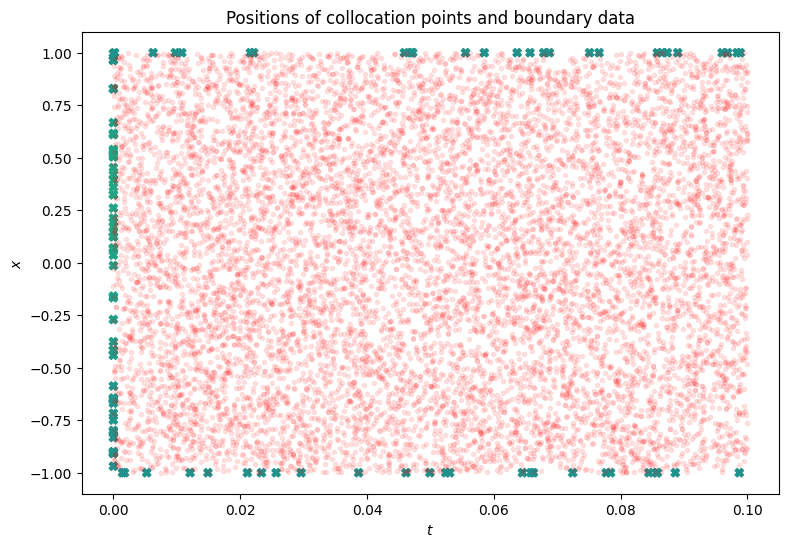

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

In [22]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(1+dim))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [23]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual 
        u = model(tf.concat([t, x], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
            
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(t, x, u, u_t, u_x, u_xx)

In [24]:
def compute_loss(model, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

In [25]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [26]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [31]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 9.14716453e-04
It 00050: loss = 8.91832577e-04
It 00100: loss = 8.69089970e-04
It 00150: loss = 8.46492883e-04
It 00200: loss = 8.24056158e-04
It 00250: loss = 8.01795104e-04
It 00300: loss = 7.79722701e-04
It 00350: loss = 7.57850823e-04
It 00400: loss = 7.36193731e-04
It 00450: loss = 7.14771799e-04
It 00500: loss = 6.93590613e-04
It 00550: loss = 6.72672933e-04
It 00600: loss = 6.52025628e-04
It 00650: loss = 6.31662901e-04
It 00700: loss = 6.11600000e-04
It 00750: loss = 5.91846474e-04
It 00800: loss = 5.72415243e-04
It 00850: loss = 5.53319580e-04
It 00900: loss = 5.34568913e-04
It 00950: loss = 5.16175060e-04
It 01000: loss = 4.98150883e-04
It 01050: loss = 4.80503659e-04
It 01100: loss = 4.63243341e-04
It 01150: loss = 4.46378806e-04
It 01200: loss = 4.29916661e-04
It 01250: loss = 4.13866190e-04
It 01300: loss = 3.98231787e-04
It 01350: loss = 3.83020408e-04
It 01400: loss = 3.68240784e-04
It 01450: loss = 3.53891199e-04
It 01500: loss = 3.39980354e-04
It 01550

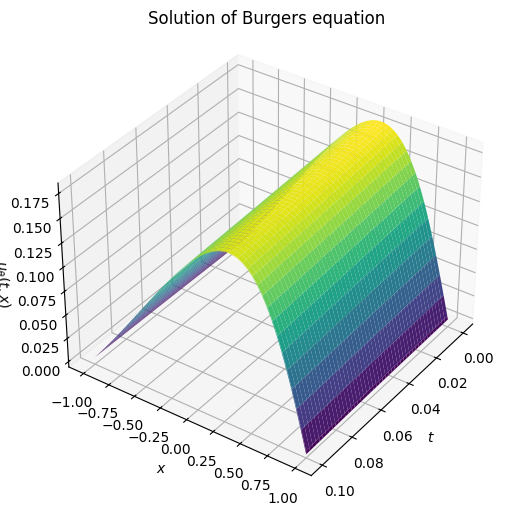

In [32]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');

In [33]:
grid = np.linspace(xmin, xmax, 100)
grid_d_dim = np.concatenate((xmin * np.ones((0, 100)), np.expand_dims(grid, axis=0), xmin * np.ones((dim - 1, 100))), axis=0)

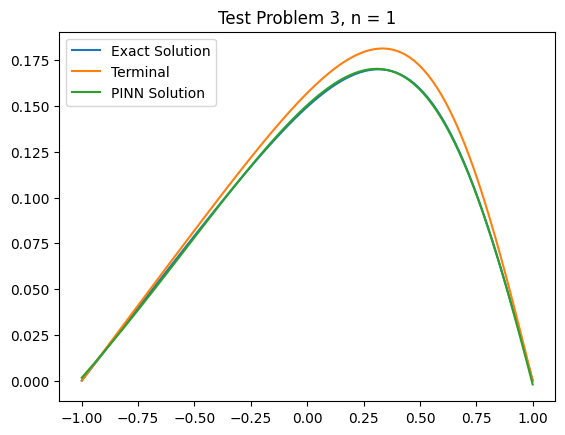

In [34]:
plt.plot(grid, exact_example(0, grid_d_dim, 0.1), label='Exact Solution')
plt.plot(grid, fun_u_0(tf.convert_to_tensor(grid_d_dim.T, dtype=float)), label='Terminal')

grid_d_dim_with_t = np.concatenate((0.1 * np.ones((1, 100)), grid_d_dim), axis=0).T
pinn_sol = model(grid_d_dim_with_t)

plt.plot(grid, pinn_sol, label='PINN Solution')
plt.title("Test Problem 3, n = 1")
plt.legend()

## 2 Dimensional

In [15]:
dim = 2

# Set number of data points
N_0 = 5000
N_b = 5000
N_r = 100000

# Set boundary
tmin = 0.
tmax = 0.1/dim
T = 0.1/dim
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin] + dim*[xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax] + dim*[xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,dim), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = np.random.uniform(size=(N_0,dim), low=lb[1], high=ub[1])
for x in x_b:
    x[random.randint(0, dim-1)] = np.random.choice([lb[1], ub[1]])
x_b = tf.convert_to_tensor(x_b, dtype=DTYPE)
                                                       
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,dim), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

In [16]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [17]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 15000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.16495247e+01
It 00050: loss = 8.56940895e-02
It 00100: loss = 3.47695500e-02
It 00150: loss = 2.54950337e-02
It 00200: loss = 2.09594816e-02
It 00250: loss = 1.84853803e-02
It 00300: loss = 1.69890542e-02
It 00350: loss = 1.59916766e-02
It 00400: loss = 1.52712129e-02
It 00450: loss = 1.47175444e-02
It 00500: loss = 1.42720770e-02
It 00550: loss = 1.39013082e-02
It 00600: loss = 1.35847256e-02
It 00650: loss = 1.33089758e-02
It 00700: loss = 1.30649284e-02
It 00750: loss = 1.28460880e-02
It 00800: loss = 1.26476856e-02
It 00850: loss = 1.24661047e-02
It 00900: loss = 1.22985430e-02
It 00950: loss = 1.21427672e-02
It 01000: loss = 1.19969584e-02
It 01050: loss = 1.19801918e-02
It 01100: loss = 1.19655840e-02
It 01150: loss = 1.19505683e-02
It 01200: loss = 1.19351633e-02
It 01250: loss = 1.19193606e-02
It 01300: loss = 1.19031779e-02
It 01350: loss = 1.18866106e-02
It 01400: loss = 1.18696652e-02
It 01450: loss = 1.18523557e-02
It 01500: loss = 1.18346764e-02
It 01550

It 12850: loss = 4.09502722e-03
It 12900: loss = 4.07814747e-03
It 12950: loss = 4.06475272e-03
It 13000: loss = 4.05152095e-03
It 13050: loss = 4.03832830e-03
It 13100: loss = 4.09161951e-03
It 13150: loss = 4.01536236e-03
It 13200: loss = 4.00226563e-03
It 13250: loss = 3.98981618e-03
It 13300: loss = 3.97749431e-03
It 13350: loss = 3.96522414e-03
It 13400: loss = 3.95332929e-03
It 13450: loss = 3.96908866e-03
It 13500: loss = 3.93188279e-03
It 13550: loss = 3.92027386e-03
It 13600: loss = 3.90889263e-03
It 13650: loss = 3.89762269e-03
It 13700: loss = 3.88645218e-03
It 13750: loss = 3.93209793e-03
It 13800: loss = 3.86737287e-03
It 13850: loss = 3.85632017e-03
It 13900: loss = 3.84597341e-03
It 13950: loss = 3.83577077e-03
It 14000: loss = 3.82568198e-03
It 14050: loss = 3.86097608e-03
It 14100: loss = 3.80832562e-03
It 14150: loss = 3.79828410e-03
It 14200: loss = 3.78884701e-03
It 14250: loss = 3.77954636e-03
It 14300: loss = 3.77031858e-03
It 14350: loss = 3.76113551e-03
It 14400

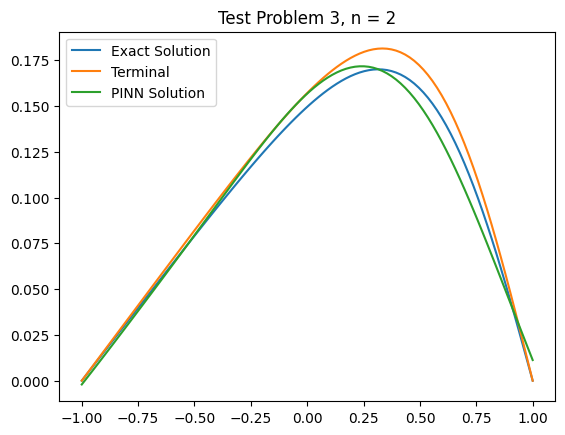

In [18]:
grid_d_dim = np.concatenate((0 * np.ones((0, 100)), np.expand_dims(grid, axis=0), 0 * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((tmax * np.ones((1, 100)), grid_d_dim), axis=0)

plt.plot(grid, exact_example(0, grid_d_dim, T), label='Exact Solution')
plt.plot(grid, fun_u_0(tf.convert_to_tensor(grid_d_dim.T, dtype=float)), label='Terminal')

grid_d_dim_with_t = np.concatenate((0.1 * np.ones((1, 100)), grid_d_dim), axis=0).T
pinn_sol = model(grid_d_dim_with_t)

plt.plot(grid, pinn_sol, label='PINN Solution')
plt.title("Test Problem 3, n = 2")
plt.legend()